Spoken digit recognition using the Free Spoken Digit Dataset (FSDD)

At first, import packages to be used for the experiments

In [1]:
import os, sys
cwd = os.getcwd()
module_path = os.path.dirname(cwd)  # target working directory

sys.path = [item for item in sys.path if item != module_path]  # remove module_path from sys.path
sys.path.append(module_path)  # add module_path to sys.path

import glob
import os
import numpy as np
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, ConfusionMatrixDisplay
from sklearn.cluster import MiniBatchKMeans, Birch
from sklearn.utils import shuffle
from joblib import Parallel, delayed, dump, load
from pyrcn.echo_state_network import SeqToLabelESNClassifier
from pyrcn.base import PredefinedWeightsInputToNode, NodeToNode
from pyrcn.metrics import accuracy_score, classification_report, confusion_matrix
from pyrcn.model_selection import SequentialSearchCV
import matplotlib
from matplotlib import pyplot as plt
#Options
plt.rc('image', cmap='RdBu')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import librosa
import librosa.display

Print number of files that are included in the dataset

In [2]:
all_files = glob.glob(r"E:\free-spoken-digit-dataset\recordings\*.wav")
print(len(all_files))

3000


Feature visualization

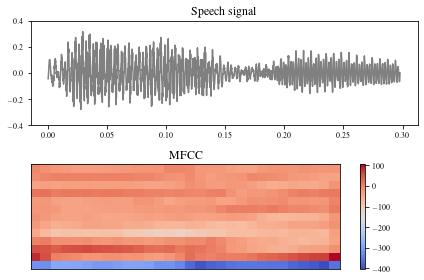

In [3]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
# X = np.vstack((mfcc, mfcc_delta, mfcc_delta2))
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

plt.subplot(2, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(2, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

Extract features and labels from all signals

In [4]:
X_train = []
X_test = []
y_train = []
y_test = []
print("extracting features...")
for k, f in enumerate(all_files):
    basename = os.path.basename(f).split('.')[0]
    # Get label (0-9) of recording.
    label = int(basename.split('_')[0])
    idx = int(basename.split('_')[2])
    # Load the audio signal and normalize it.
    x, sr = librosa.core.load(f, sr=None, mono=False)
    # x /= np.max(np.abs(x))
    mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    if idx <= 4:
        X_test.append(mfcc.T)
        y_test.append(label)
    else:
        X_train.append(mfcc.T)
        y_train.append(label)
print("done!")

extracting features...
done!


## Normalize all features using the StandardScaler from scikit-learn."

In [5]:
scaler = StandardScaler().fit(X=np.vstack(X_train))
X_train_scaled = np.empty(shape=(len(X_train),), dtype=object)
X_test_scaled = np.empty(shape=(len(X_test),), dtype=object)
y_train = np.array(y_train, dtype=object)
X_train, X_train_scaled, y_train = shuffle(X_train, X_train_scaled, y_train)
y_test = np.array(y_test, dtype=object)
for k in range(len(X_train)):
    X_train_scaled[k] = scaler.transform(X_train[k])
    y_train[k] = np.atleast_1d(y_train[k]).astype(int)
for k in range(len(X_test)):
    X_test_scaled[k] = scaler.transform(X_test[k])
    y_test[k] = np.atleast_1d(y_test[k]).astype(int)

Validate training and test sizes

In [6]:
print(len(X_train), len(y_train), X_train[0].shape, y_train[0])
print(len(X_test), len(y_test), X_test[0].shape, y_test[0])

2700 2700 (38, 13) [6]
300 300 (30, 13) [0]


Feature visualization

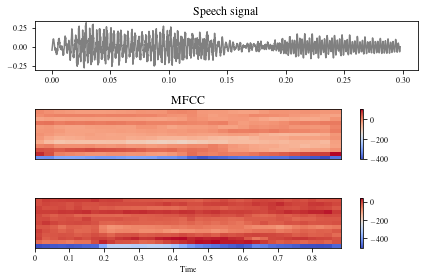

In [7]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

plt.subplot(3, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
# plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(3, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(X_train[0].T, x_axis='time')
plt.colorbar()
plt.tight_layout()

Hyperparameter optimization

In [8]:
initially_fixed_params = {'hidden_layer_size': 100,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 0.0,
                          'leakage': 0.1,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bi_directional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-3,
                          'random_state': 42}

step1_esn_params = {'input_scaling': np.linspace(0.1, 1.0, 10),
                    'spectral_radius': np.linspace(0.0, 1.0, 11)}

step2_esn_params = {'leakage': np.linspace(0.1, 1.0, 10)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}
step4_esn_params = {'alpha': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e0]}

kwargs = {'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', GridSearchCV, step1_esn_params, kwargs),
            ('step2', GridSearchCV, step2_esn_params, kwargs),
            ('step3', GridSearchCV, step3_esn_params, kwargs),
            ('step4', GridSearchCV, step4_esn_params, kwargs)]

base_esn = SeqToLabelESNClassifier(**initially_fixed_params)

try:
    sequential_search = load("sequential_search.joblib")
except FileNotFoundError:
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(X_train_scaled, y_train)
    dump(sequential_search, "sequential_search.joblib")

Get the final ESN model

In [9]:
esn = sequential_search.best_estimator_

Test the model on the training and test set

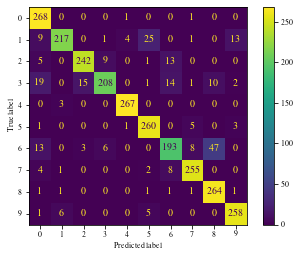

Classification training report for estimator SeqToLabelESNClassifier(input_to_node=InputToNode(hidden_layer_size=100,
                                                  input_activation='identity',
                                                  input_scaling=0.30000000000000004,
                                                  k_in=10,
                                                  sparsity=0.7692307692307693),
                        node_to_node=NodeToNode(continuation=False,
                                                hidden_layer_size=100, k_rec=10,
                                                leakage=0.1, sparsity=0.1,
                                                spectral_radius=0.7000000000000001),
                        regressor=IncrementalRegression()):
              precision    recall  f1-score   support

           0  0.8348909657 0.9925925926 0.9069373942       270
           1  0.9517543860 0.8037037037 0.8714859438       270
           2  0.9307692308 0.

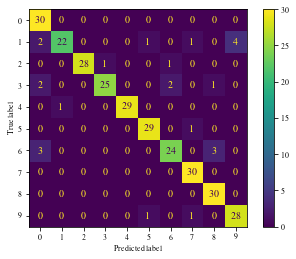

Classification test report for estimator SeqToLabelESNClassifier(input_to_node=InputToNode(hidden_layer_size=100,
                                                  input_activation='identity',
                                                  input_scaling=0.30000000000000004,
                                                  k_in=10,
                                                  sparsity=0.7692307692307693),
                        node_to_node=NodeToNode(continuation=False,
                                                hidden_layer_size=100, k_rec=10,
                                                leakage=0.1, sparsity=0.1,
                                                spectral_radius=0.7000000000000001),
                        regressor=IncrementalRegression()):
              precision    recall  f1-score   support

           0  0.8108108108 1.0000000000 0.8955223881        30
           1  0.9565217391 0.7333333333 0.8301886792        30
           2  1.0000000000 0.9333

In [10]:
y_pred_train = esn.predict(X=X_train_scaled)
cm = confusion_matrix(y_train, y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
plt.show()
print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(y_train, y_pred_train, digits=10)))

y_pred_test = esn.predict(X=X_test_scaled)
cm = confusion_matrix(y_test, y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
plt.show()
print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(y_test, y_pred_test, digits=10)))

Visualization of features from the training set

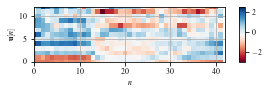

In [11]:
fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
ax = plt.gca()
im = plt.imshow(X_train_scaled[361].T,vmin=np.min(X_train_scaled[361]), vmax=np.max(X_train_scaled[361]))
plt.xlim([0,X_train_scaled[361].shape[0]])
plt.ylim([0, X_train_scaled[361].shape[1] - 1])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{u}[n]$')
# plt.colorbar(im)
plt.grid()
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
width = 3.487
height =3 * width / 1.618
plt.colorbar(im, cax=cax)
fig.set_size_inches(width, height)
# plt.savefig('features_train.pdf', bbox_inches = 'tight', pad_inches = 0)

Visualizations of features from the test set

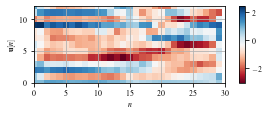

In [12]:
fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
ax = plt.gca()
im = plt.imshow(X_test_scaled[0].T,vmin=np.min(X_test_scaled[0]), vmax=np.max(X_test_scaled[0]))
plt.xlim([0, X_test[0].shape[0]])
plt.ylim([0, X_test[0].shape[1] - 1])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{u}[n]$')
# plt.colorbar(im)
plt.grid()
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)

plt.colorbar(im, cax=cax)
fig.set_size_inches(width, height)
# plt.savefig('features_test.pdf', bbox_inches = 'tight', pad_inches = 0)

Visualization of a reservoir state from the training set

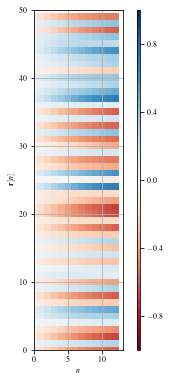

In [13]:
_ = esn.predict(X=X_train_scaled[361])
fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
ax = plt.gca()
rng = np.random.default_rng(12345)
idx = rng.choice(100, 50)
im = plt.imshow(esn.hidden_layer_state[:, idx].T,vmin=-1, vmax=1)
plt.xlim([0, esn.hidden_layer_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.grid()
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
tick_locator = ticker.MaxNLocator(nbins=5)
cb = plt.colorbar(im, cax=cax)
cb.locator = tick_locator
cb.update_ticks()
fig.set_size_inches(0.5*width, height)
# plt.savefig('input_scaling_rand_train.pdf', bbox_inches = 'tight', pad_inches = 0)

# print(f_name_train[361])

Visualization of a reservoir state from the test set

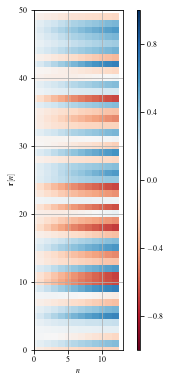

In [14]:
_ = esn.predict(X=X_test_scaled[0])
fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
ax = plt.gca()
rng = np.random.default_rng(12345)
idx = rng.choice(100, 50)
im = plt.imshow(esn.hidden_layer_state[:, idx].T,vmin=-1, vmax=1)
plt.xlim([0, esn.hidden_layer_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.grid()
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cb = plt.colorbar(im, cax=cax)
cb.locator = tick_locator
cb.update_ticks()
fig.set_size_inches(0.5*width, height)
# plt.savefig('spectral_radius_rand_test.pdf', bbox_inches = 'tight', pad_inches = 0)

Random experiments

In [18]:
rng = np.random.default_rng(12345)
params = {"random_state": rng.integers(100, size=20)}
gs_rand_esn = GridSearchCV(clone(esn), params, scoring=make_scorer(accuracy_score), n_jobs=-1).fit(X_train_scaled, y_train)

In [23]:
gs_rand_esn.cv_results_["mean_test_score"].mean(), gs_rand_esn.cv_results_["mean_test_score"].var()

(0.8913333333333334, 4.875720164609012e-05)

K-Means Clustering

In [24]:
kmeans = MiniBatchKMeans(n_clusters=100, n_init=20, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=2, random_state=0)
kmeans.fit(X=np.concatenate(X_train_scaled))
w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])

Init 1/20 with method: k-means++
Inertia for init 1/20: 1002.953918
Init 2/20 with method: k-means++
Inertia for init 2/20: 1151.442871
Init 3/20 with method: k-means++
Inertia for init 3/20: 1022.761169
Init 4/20 with method: k-means++
Inertia for init 4/20: 972.466919
Init 5/20 with method: k-means++
Inertia for init 5/20: 997.416382
Init 6/20 with method: k-means++
Inertia for init 6/20: 1025.126221
Init 7/20 with method: k-means++
Inertia for init 7/20: 1041.690918
Init 8/20 with method: k-means++
Inertia for init 8/20: 1004.365784
Init 9/20 with method: k-means++
Inertia for init 9/20: 1040.971436
Init 10/20 with method: k-means++
Inertia for init 10/20: 952.360291
Init 11/20 with method: k-means++
Inertia for init 11/20: 983.955444
Init 12/20 with method: k-means++
Inertia for init 12/20: 1062.705322
Init 13/20 with method: k-means++
Inertia for init 13/20: 1024.413574
Init 14/20 with method: k-means++
Inertia for init 14/20: 1013.824341
Init 15/20 with method: k-means++
Inertia 

Minibatch iteration 82/119700: mean batch inertia: 4.097696, ewa inertia: 5.327546 
Minibatch iteration 83/119700: mean batch inertia: 4.354796, ewa inertia: 5.325921 
Minibatch iteration 84/119700: mean batch inertia: 3.819624, ewa inertia: 5.323403 
Minibatch iteration 85/119700: mean batch inertia: 4.129861, ewa inertia: 5.321408 
Minibatch iteration 86/119700: mean batch inertia: 3.941053, ewa inertia: 5.319101 
Minibatch iteration 87/119700: mean batch inertia: 4.347291, ewa inertia: 5.317477 
Minibatch iteration 88/119700: mean batch inertia: 4.082610, ewa inertia: 5.315413 
Minibatch iteration 89/119700: mean batch inertia: 4.430188, ewa inertia: 5.313934 
Minibatch iteration 90/119700: mean batch inertia: 4.217444, ewa inertia: 5.312101 
Minibatch iteration 91/119700: mean batch inertia: 4.297688, ewa inertia: 5.310406 
Minibatch iteration 92/119700: mean batch inertia: 4.063288, ewa inertia: 5.308322 
Minibatch iteration 93/119700: mean batch inertia: 4.084858, ewa inertia: 5.

Minibatch iteration 178/119700: mean batch inertia: 4.160384, ewa inertia: 5.155853 
Minibatch iteration 179/119700: mean batch inertia: 4.101355, ewa inertia: 5.154091 
Minibatch iteration 180/119700: mean batch inertia: 4.253702, ewa inertia: 5.152586 
Minibatch iteration 181/119700: mean batch inertia: 4.038629, ewa inertia: 5.150725 
Minibatch iteration 182/119700: mean batch inertia: 4.087619, ewa inertia: 5.148948 
Minibatch iteration 183/119700: mean batch inertia: 4.137551, ewa inertia: 5.147257 
Minibatch iteration 184/119700: mean batch inertia: 3.853909, ewa inertia: 5.145096 
Minibatch iteration 185/119700: mean batch inertia: 4.006975, ewa inertia: 5.143194 
Minibatch iteration 186/119700: mean batch inertia: 3.871098, ewa inertia: 5.141068 
Minibatch iteration 187/119700: mean batch inertia: 4.347292, ewa inertia: 5.139741 
Minibatch iteration 188/119700: mean batch inertia: 4.332951, ewa inertia: 5.138393 
Minibatch iteration 189/119700: mean batch inertia: 4.125172, ewa

Minibatch iteration 274/119700: mean batch inertia: 3.956362, ewa inertia: 5.003973 
Minibatch iteration 275/119700: mean batch inertia: 4.306812, ewa inertia: 5.002808 
Minibatch iteration 276/119700: mean batch inertia: 4.066976, ewa inertia: 5.001244 
Minibatch iteration 277/119700: mean batch inertia: 3.985672, ewa inertia: 4.999546 
Minibatch iteration 278/119700: mean batch inertia: 4.002036, ewa inertia: 4.997879 
Minibatch iteration 279/119700: mean batch inertia: 4.125750, ewa inertia: 4.996422 
Minibatch iteration 280/119700: mean batch inertia: 4.267112, ewa inertia: 4.995203 
Minibatch iteration 281/119700: mean batch inertia: 4.330548, ewa inertia: 4.994092 
Minibatch iteration 282/119700: mean batch inertia: 4.295723, ewa inertia: 4.992925 
Minibatch iteration 283/119700: mean batch inertia: 4.106370, ewa inertia: 4.991443 
Minibatch iteration 284/119700: mean batch inertia: 4.147129, ewa inertia: 4.990032 
Minibatch iteration 285/119700: mean batch inertia: 4.030823, ewa

Minibatch iteration 370/119700: mean batch inertia: 4.301357, ewa inertia: 4.869730 
Minibatch iteration 371/119700: mean batch inertia: 4.452588, ewa inertia: 4.869033 
Minibatch iteration 372/119700: mean batch inertia: 3.951407, ewa inertia: 4.867499 
Minibatch iteration 373/119700: mean batch inertia: 4.096232, ewa inertia: 4.866210 
Minibatch iteration 374/119700: mean batch inertia: 3.905302, ewa inertia: 4.864604 
Minibatch iteration 375/119700: mean batch inertia: 3.812072, ewa inertia: 4.862845 
Minibatch iteration 376/119700: mean batch inertia: 4.283620, ewa inertia: 4.861877 
Minibatch iteration 377/119700: mean batch inertia: 4.246478, ewa inertia: 4.860848 
Minibatch iteration 378/119700: mean batch inertia: 3.957778, ewa inertia: 4.859339 
Minibatch iteration 379/119700: mean batch inertia: 4.037760, ewa inertia: 4.857966 
Minibatch iteration 380/119700: mean batch inertia: 3.863549, ewa inertia: 4.856304 
Minibatch iteration 381/119700: mean batch inertia: 4.016566, ewa

Minibatch iteration 466/119700: mean batch inertia: 4.305589, ewa inertia: 4.752159 
Minibatch iteration 467/119700: mean batch inertia: 3.872382, ewa inertia: 4.750689 
Minibatch iteration 468/119700: mean batch inertia: 3.773402, ewa inertia: 4.749055 
Minibatch iteration 469/119700: mean batch inertia: 4.180319, ewa inertia: 4.748105 
Minibatch iteration 470/119700: mean batch inertia: 4.043528, ewa inertia: 4.746927 
Minibatch iteration 471/119700: mean batch inertia: 4.099894, ewa inertia: 4.745846 
Minibatch iteration 472/119700: mean batch inertia: 3.819516, ewa inertia: 4.744298 
Minibatch iteration 473/119700: mean batch inertia: 4.070830, ewa inertia: 4.743172 
Minibatch iteration 474/119700: mean batch inertia: 3.925031, ewa inertia: 4.741805 
Minibatch iteration 475/119700: mean batch inertia: 4.152767, ewa inertia: 4.740820 
Minibatch iteration 476/119700: mean batch inertia: 4.208614, ewa inertia: 4.739931 
Minibatch iteration 477/119700: mean batch inertia: 3.884902, ewa

Minibatch iteration 562/119700: mean batch inertia: 3.933254, ewa inertia: 4.653441 
Minibatch iteration 563/119700: mean batch inertia: 3.934271, ewa inertia: 4.652239 
Minibatch iteration 564/119700: mean batch inertia: 4.171644, ewa inertia: 4.651436 
Minibatch iteration 565/119700: mean batch inertia: 4.111123, ewa inertia: 4.650533 
Minibatch iteration 566/119700: mean batch inertia: 4.378885, ewa inertia: 4.650079 
Minibatch iteration 567/119700: mean batch inertia: 4.250887, ewa inertia: 4.649411 
Minibatch iteration 568/119700: mean batch inertia: 3.750194, ewa inertia: 4.647908 
Minibatch iteration 569/119700: mean batch inertia: 4.249884, ewa inertia: 4.647243 
Minibatch iteration 570/119700: mean batch inertia: 4.046075, ewa inertia: 4.646239 
Minibatch iteration 571/119700: mean batch inertia: 3.857702, ewa inertia: 4.644921 
Minibatch iteration 572/119700: mean batch inertia: 3.917274, ewa inertia: 4.643705 
Minibatch iteration 573/119700: mean batch inertia: 4.299840, ewa

Minibatch iteration 658/119700: mean batch inertia: 3.878398, ewa inertia: 4.571161 
Minibatch iteration 659/119700: mean batch inertia: 4.150820, ewa inertia: 4.570458 
Minibatch iteration 660/119700: mean batch inertia: 4.099569, ewa inertia: 4.569671 
Minibatch iteration 661/119700: mean batch inertia: 4.454224, ewa inertia: 4.569478 
Minibatch iteration 662/119700: mean batch inertia: 4.163418, ewa inertia: 4.568800 
Minibatch iteration 663/119700: mean batch inertia: 4.162700, ewa inertia: 4.568121 
Minibatch iteration 664/119700: mean batch inertia: 4.100506, ewa inertia: 4.567340 
Minibatch iteration 665/119700: mean batch inertia: 3.703969, ewa inertia: 4.565897 
Minibatch iteration 666/119700: mean batch inertia: 4.082766, ewa inertia: 4.565089 
Minibatch iteration 667/119700: mean batch inertia: 4.069285, ewa inertia: 4.564261 
Minibatch iteration 668/119700: mean batch inertia: 4.164174, ewa inertia: 4.563592 
Minibatch iteration 669/119700: mean batch inertia: 3.610738, ewa

Minibatch iteration 754/119700: mean batch inertia: 3.866239, ewa inertia: 4.494697 
Minibatch iteration 755/119700: mean batch inertia: 4.250446, ewa inertia: 4.494288 
Minibatch iteration 756/119700: mean batch inertia: 4.102110, ewa inertia: 4.493633 
Minibatch iteration 757/119700: mean batch inertia: 4.035054, ewa inertia: 4.492867 
Minibatch iteration 758/119700: mean batch inertia: 3.854419, ewa inertia: 4.491800 
Minibatch iteration 759/119700: mean batch inertia: 4.463741, ewa inertia: 4.491753 
Minibatch iteration 760/119700: mean batch inertia: 4.208155, ewa inertia: 4.491279 
Minibatch iteration 761/119700: mean batch inertia: 3.819487, ewa inertia: 4.490156 
Minibatch iteration 762/119700: mean batch inertia: 4.118989, ewa inertia: 4.489536 
Minibatch iteration 763/119700: mean batch inertia: 3.921540, ewa inertia: 4.488586 
Minibatch iteration 764/119700: mean batch inertia: 4.297422, ewa inertia: 4.488267 
Minibatch iteration 765/119700: mean batch inertia: 4.127984, ewa

Minibatch iteration 850/119700: mean batch inertia: 4.114475, ewa inertia: 4.432223 
Minibatch iteration 851/119700: mean batch inertia: 3.983342, ewa inertia: 4.431473 
Minibatch iteration 852/119700: mean batch inertia: 3.543144, ewa inertia: 4.429988 
Minibatch iteration 853/119700: mean batch inertia: 4.049937, ewa inertia: 4.429353 
Minibatch iteration 854/119700: mean batch inertia: 3.878253, ewa inertia: 4.428432 
Minibatch iteration 855/119700: mean batch inertia: 3.957489, ewa inertia: 4.427645 
Minibatch iteration 856/119700: mean batch inertia: 4.221325, ewa inertia: 4.427300 
Minibatch iteration 857/119700: mean batch inertia: 3.979483, ewa inertia: 4.426552 
Minibatch iteration 858/119700: mean batch inertia: 4.037946, ewa inertia: 4.425902 
Minibatch iteration 859/119700: mean batch inertia: 4.108808, ewa inertia: 4.425373 
Minibatch iteration 860/119700: mean batch inertia: 3.965111, ewa inertia: 4.424603 
Minibatch iteration 861/119700: mean batch inertia: 3.918495, ewa

Minibatch iteration 946/119700: mean batch inertia: 3.956620, ewa inertia: 4.381563 
Minibatch iteration 947/119700: mean batch inertia: 4.236210, ewa inertia: 4.381320 
Minibatch iteration 948/119700: mean batch inertia: 3.927236, ewa inertia: 4.380561 
Minibatch iteration 949/119700: mean batch inertia: 3.744179, ewa inertia: 4.379497 
Minibatch iteration 950/119700: mean batch inertia: 4.140821, ewa inertia: 4.379098 
Minibatch iteration 951/119700: mean batch inertia: 4.077141, ewa inertia: 4.378594 
Minibatch iteration 952/119700: mean batch inertia: 4.535387, ewa inertia: 4.378856 
Minibatch iteration 953/119700: mean batch inertia: 3.978608, ewa inertia: 4.378187 
Minibatch iteration 954/119700: mean batch inertia: 3.822319, ewa inertia: 4.377258 
Minibatch iteration 955/119700: mean batch inertia: 3.954134, ewa inertia: 4.376551 
Minibatch iteration 956/119700: mean batch inertia: 3.873640, ewa inertia: 4.375710 
Minibatch iteration 957/119700: mean batch inertia: 4.085774, ewa

Minibatch iteration 1041/119700: mean batch inertia: 3.925262, ewa inertia: 4.333013 
Minibatch iteration 1042/119700: mean batch inertia: 3.976952, ewa inertia: 4.332418 
Minibatch iteration 1043/119700: mean batch inertia: 3.800970, ewa inertia: 4.331530 
Minibatch iteration 1044/119700: mean batch inertia: 4.234567, ewa inertia: 4.331368 
Minibatch iteration 1045/119700: mean batch inertia: 4.514259, ewa inertia: 4.331673 
Minibatch iteration 1046/119700: mean batch inertia: 4.177131, ewa inertia: 4.331415 
Minibatch iteration 1047/119700: mean batch inertia: 4.023393, ewa inertia: 4.330900 
Minibatch iteration 1048/119700: mean batch inertia: 4.109655, ewa inertia: 4.330531 
Minibatch iteration 1049/119700: mean batch inertia: 4.186291, ewa inertia: 4.330289 
Minibatch iteration 1050/119700: mean batch inertia: 3.663372, ewa inertia: 4.329175 
Minibatch iteration 1051/119700: mean batch inertia: 3.934952, ewa inertia: 4.328516 
Minibatch iteration 1052/119700: mean batch inertia: 4

Minibatch iteration 1136/119700: mean batch inertia: 3.704316, ewa inertia: 4.291746 
Minibatch iteration 1137/119700: mean batch inertia: 3.953196, ewa inertia: 4.291180 
Minibatch iteration 1138/119700: mean batch inertia: 4.043108, ewa inertia: 4.290765 
Minibatch iteration 1139/119700: mean batch inertia: 4.235435, ewa inertia: 4.290673 
Minibatch iteration 1140/119700: mean batch inertia: 4.175995, ewa inertia: 4.290481 
Minibatch iteration 1141/119700: mean batch inertia: 3.936234, ewa inertia: 4.289889 
Minibatch iteration 1142/119700: mean batch inertia: 4.455685, ewa inertia: 4.290166 
Minibatch iteration 1143/119700: mean batch inertia: 4.019894, ewa inertia: 4.289714 
Minibatch iteration 1144/119700: mean batch inertia: 4.220132, ewa inertia: 4.289598 
Minibatch iteration 1145/119700: mean batch inertia: 4.420233, ewa inertia: 4.289816 
Minibatch iteration 1146/119700: mean batch inertia: 4.199662, ewa inertia: 4.289666 
Minibatch iteration 1147/119700: mean batch inertia: 3

Minibatch iteration 1231/119700: mean batch inertia: 3.700228, ewa inertia: 4.260392 
Minibatch iteration 1232/119700: mean batch inertia: 3.798243, ewa inertia: 4.259620 
Minibatch iteration 1233/119700: mean batch inertia: 4.137094, ewa inertia: 4.259415 
Minibatch iteration 1234/119700: mean batch inertia: 4.236434, ewa inertia: 4.259376 
Minibatch iteration 1235/119700: mean batch inertia: 4.744177, ewa inertia: 4.260187 
Minibatch iteration 1236/119700: mean batch inertia: 3.801044, ewa inertia: 4.259419 
Minibatch iteration 1237/119700: mean batch inertia: 4.222562, ewa inertia: 4.259358 
Minibatch iteration 1238/119700: mean batch inertia: 3.942623, ewa inertia: 4.258828 
Minibatch iteration 1239/119700: mean batch inertia: 4.516388, ewa inertia: 4.259259 
Minibatch iteration 1240/119700: mean batch inertia: 4.290937, ewa inertia: 4.259312 
Minibatch iteration 1241/119700: mean batch inertia: 4.359016, ewa inertia: 4.259478 
Minibatch iteration 1242/119700: mean batch inertia: 3

Minibatch iteration 1326/119700: mean batch inertia: 4.313344, ewa inertia: 4.229727 
Minibatch iteration 1327/119700: mean batch inertia: 4.145824, ewa inertia: 4.229587 
Minibatch iteration 1328/119700: mean batch inertia: 3.886185, ewa inertia: 4.229013 
Minibatch iteration 1329/119700: mean batch inertia: 4.285385, ewa inertia: 4.229107 
Minibatch iteration 1330/119700: mean batch inertia: 3.783605, ewa inertia: 4.228363 
Minibatch iteration 1331/119700: mean batch inertia: 3.748668, ewa inertia: 4.227561 
Minibatch iteration 1332/119700: mean batch inertia: 4.363759, ewa inertia: 4.227789 
Minibatch iteration 1333/119700: mean batch inertia: 3.792267, ewa inertia: 4.227061 
Minibatch iteration 1334/119700: mean batch inertia: 4.176967, ewa inertia: 4.226977 
Minibatch iteration 1335/119700: mean batch inertia: 3.793890, ewa inertia: 4.226253 
Minibatch iteration 1336/119700: mean batch inertia: 4.034630, ewa inertia: 4.225933 
Minibatch iteration 1337/119700: mean batch inertia: 4

Minibatch iteration 1421/119700: mean batch inertia: 4.063378, ewa inertia: 4.201494 
Minibatch iteration 1422/119700: mean batch inertia: 4.257011, ewa inertia: 4.201587 
Minibatch iteration 1423/119700: mean batch inertia: 3.960561, ewa inertia: 4.201184 
Minibatch iteration 1424/119700: mean batch inertia: 3.747652, ewa inertia: 4.200426 
Minibatch iteration 1425/119700: mean batch inertia: 4.538131, ewa inertia: 4.200990 
Minibatch iteration 1426/119700: mean batch inertia: 4.124722, ewa inertia: 4.200863 
Minibatch iteration 1427/119700: mean batch inertia: 3.943775, ewa inertia: 4.200433 
Minibatch iteration 1428/119700: mean batch inertia: 4.139581, ewa inertia: 4.200331 
Minibatch iteration 1429/119700: mean batch inertia: 4.053210, ewa inertia: 4.200085 
Minibatch iteration 1430/119700: mean batch inertia: 3.794803, ewa inertia: 4.199408 
Minibatch iteration 1431/119700: mean batch inertia: 4.132792, ewa inertia: 4.199297 
Minibatch iteration 1432/119700: mean batch inertia: 3

Minibatch iteration 1516/119700: mean batch inertia: 4.080172, ewa inertia: 4.179060 
Minibatch iteration 1517/119700: mean batch inertia: 4.162309, ewa inertia: 4.179032 
Minibatch iteration 1518/119700: mean batch inertia: 4.174941, ewa inertia: 4.179025 
Minibatch iteration 1519/119700: mean batch inertia: 4.172849, ewa inertia: 4.179015 
Minibatch iteration 1520/119700: mean batch inertia: 3.733740, ewa inertia: 4.178271 
Minibatch iteration 1521/119700: mean batch inertia: 4.621017, ewa inertia: 4.179011 
Minibatch iteration 1522/119700: mean batch inertia: 4.244669, ewa inertia: 4.179120 
Minibatch iteration 1523/119700: mean batch inertia: 3.890120, ewa inertia: 4.178637 
Minibatch iteration 1524/119700: mean batch inertia: 3.915284, ewa inertia: 4.178197 
Minibatch iteration 1525/119700: mean batch inertia: 3.913544, ewa inertia: 4.177755 
Minibatch iteration 1526/119700: mean batch inertia: 4.028855, ewa inertia: 4.177506 
Minibatch iteration 1527/119700: mean batch inertia: 4

Minibatch iteration 1611/119700: mean batch inertia: 3.802039, ewa inertia: 4.163493 
Minibatch iteration 1612/119700: mean batch inertia: 4.083050, ewa inertia: 4.163359 
Minibatch iteration 1613/119700: mean batch inertia: 3.649106, ewa inertia: 4.162499 
Minibatch iteration 1614/119700: mean batch inertia: 3.743515, ewa inertia: 4.161799 
Minibatch iteration 1615/119700: mean batch inertia: 4.039148, ewa inertia: 4.161594 
Minibatch iteration 1616/119700: mean batch inertia: 4.005742, ewa inertia: 4.161334 
Minibatch iteration 1617/119700: mean batch inertia: 4.155827, ewa inertia: 4.161325 
Minibatch iteration 1618/119700: mean batch inertia: 4.150630, ewa inertia: 4.161307 
Minibatch iteration 1619/119700: mean batch inertia: 3.993245, ewa inertia: 4.161026 
Minibatch iteration 1620/119700: mean batch inertia: 4.432286, ewa inertia: 4.161479 
Minibatch iteration 1621/119700: mean batch inertia: 3.735125, ewa inertia: 4.160767 
Minibatch iteration 1622/119700: mean batch inertia: 4

Minibatch iteration 1706/119700: mean batch inertia: 4.035332, ewa inertia: 4.149455 
Minibatch iteration 1707/119700: mean batch inertia: 3.531167, ewa inertia: 4.148421 
Minibatch iteration 1708/119700: mean batch inertia: 3.796538, ewa inertia: 4.147833 
Minibatch iteration 1709/119700: mean batch inertia: 4.204153, ewa inertia: 4.147928 
Minibatch iteration 1710/119700: mean batch inertia: 4.017683, ewa inertia: 4.147710 
Minibatch iteration 1711/119700: mean batch inertia: 3.831730, ewa inertia: 4.147182 
Minibatch iteration 1712/119700: mean batch inertia: 4.218965, ewa inertia: 4.147302 
Minibatch iteration 1713/119700: mean batch inertia: 4.329325, ewa inertia: 4.147606 
Minibatch iteration 1714/119700: mean batch inertia: 3.668984, ewa inertia: 4.146806 
Minibatch iteration 1715/119700: mean batch inertia: 3.902054, ewa inertia: 4.146397 
Minibatch iteration 1716/119700: mean batch inertia: 4.264167, ewa inertia: 4.146594 
Minibatch iteration 1717/119700: mean batch inertia: 4

Minibatch iteration 1801/119700: mean batch inertia: 4.060805, ewa inertia: 4.139155 
Minibatch iteration 1802/119700: mean batch inertia: 4.215837, ewa inertia: 4.139283 
Minibatch iteration 1803/119700: mean batch inertia: 4.069357, ewa inertia: 4.139166 
Minibatch iteration 1804/119700: mean batch inertia: 3.801097, ewa inertia: 4.138601 
Minibatch iteration 1805/119700: mean batch inertia: 4.059761, ewa inertia: 4.138469 
Minibatch iteration 1806/119700: mean batch inertia: 3.879397, ewa inertia: 4.138036 
Minibatch iteration 1807/119700: mean batch inertia: 4.000838, ewa inertia: 4.137807 
Minibatch iteration 1808/119700: mean batch inertia: 4.184771, ewa inertia: 4.137885 
Minibatch iteration 1809/119700: mean batch inertia: 3.933895, ewa inertia: 4.137544 
Minibatch iteration 1810/119700: mean batch inertia: 4.482826, ewa inertia: 4.138121 
Minibatch iteration 1811/119700: mean batch inertia: 4.062410, ewa inertia: 4.137995 
Minibatch iteration 1812/119700: mean batch inertia: 4

Minibatch iteration 1896/119700: mean batch inertia: 3.932714, ewa inertia: 4.129641 
Minibatch iteration 1897/119700: mean batch inertia: 4.488604, ewa inertia: 4.130241 
Minibatch iteration 1898/119700: mean batch inertia: 4.033545, ewa inertia: 4.130080 
Minibatch iteration 1899/119700: mean batch inertia: 4.188871, ewa inertia: 4.130178 
Minibatch iteration 1900/119700: mean batch inertia: 4.536850, ewa inertia: 4.130858 
Minibatch iteration 1901/119700: mean batch inertia: 4.305494, ewa inertia: 4.131149 
Minibatch iteration 1902/119700: mean batch inertia: 4.002717, ewa inertia: 4.130935 
Minibatch iteration 1903/119700: mean batch inertia: 4.069633, ewa inertia: 4.130832 
Minibatch iteration 1904/119700: mean batch inertia: 3.968162, ewa inertia: 4.130561 
Minibatch iteration 1905/119700: mean batch inertia: 4.117348, ewa inertia: 4.130538 
Minibatch iteration 1906/119700: mean batch inertia: 4.041373, ewa inertia: 4.130389 
Minibatch iteration 1907/119700: mean batch inertia: 3

Minibatch iteration 1991/119700: mean batch inertia: 4.060450, ewa inertia: 4.117880 
Minibatch iteration 1992/119700: mean batch inertia: 3.890279, ewa inertia: 4.117499 
Minibatch iteration 1993/119700: mean batch inertia: 3.839005, ewa inertia: 4.117034 
Minibatch iteration 1994/119700: mean batch inertia: 4.228417, ewa inertia: 4.117220 
Minibatch iteration 1995/119700: mean batch inertia: 4.187487, ewa inertia: 4.117337 
Minibatch iteration 1996/119700: mean batch inertia: 4.294240, ewa inertia: 4.117633 
Minibatch iteration 1997/119700: mean batch inertia: 4.024370, ewa inertia: 4.117477 
Minibatch iteration 1998/119700: mean batch inertia: 4.006592, ewa inertia: 4.117292 
Minibatch iteration 1999/119700: mean batch inertia: 3.868004, ewa inertia: 4.116875 
Minibatch iteration 2000/119700: mean batch inertia: 3.733442, ewa inertia: 4.116234 
Minibatch iteration 2001/119700: mean batch inertia: 3.748231, ewa inertia: 4.115619 
Minibatch iteration 2002/119700: mean batch inertia: 4

Minibatch iteration 2086/119700: mean batch inertia: 4.245725, ewa inertia: 4.108692 
Minibatch iteration 2087/119700: mean batch inertia: 3.831301, ewa inertia: 4.108228 
Minibatch iteration 2088/119700: mean batch inertia: 4.162106, ewa inertia: 4.108318 
Minibatch iteration 2089/119700: mean batch inertia: 3.783708, ewa inertia: 4.107776 
Minibatch iteration 2090/119700: mean batch inertia: 4.088944, ewa inertia: 4.107744 
Minibatch iteration 2091/119700: mean batch inertia: 4.059704, ewa inertia: 4.107664 
Minibatch iteration 2092/119700: mean batch inertia: 4.727137, ewa inertia: 4.108699 
Minibatch iteration 2093/119700: mean batch inertia: 4.179904, ewa inertia: 4.108818 
Minibatch iteration 2094/119700: mean batch inertia: 4.328988, ewa inertia: 4.109186 
Minibatch iteration 2095/119700: mean batch inertia: 4.340424, ewa inertia: 4.109573 
Minibatch iteration 2096/119700: mean batch inertia: 3.767082, ewa inertia: 4.109000 
Minibatch iteration 2097/119700: mean batch inertia: 4

Minibatch iteration 2181/119700: mean batch inertia: 3.834176, ewa inertia: 4.097588 
Minibatch iteration 2182/119700: mean batch inertia: 3.893963, ewa inertia: 4.097247 
Minibatch iteration 2183/119700: mean batch inertia: 3.959931, ewa inertia: 4.097018 
Minibatch iteration 2184/119700: mean batch inertia: 4.028819, ewa inertia: 4.096904 
Minibatch iteration 2185/119700: mean batch inertia: 4.021257, ewa inertia: 4.096778 
Minibatch iteration 2186/119700: mean batch inertia: 4.015109, ewa inertia: 4.096641 
Minibatch iteration 2187/119700: mean batch inertia: 4.116023, ewa inertia: 4.096673 
Minibatch iteration 2188/119700: mean batch inertia: 3.926662, ewa inertia: 4.096389 
Minibatch iteration 2189/119700: mean batch inertia: 3.885573, ewa inertia: 4.096037 
Minibatch iteration 2190/119700: mean batch inertia: 3.540894, ewa inertia: 4.095109 
Minibatch iteration 2191/119700: mean batch inertia: 4.219761, ewa inertia: 4.095318 
Minibatch iteration 2192/119700: mean batch inertia: 4

Minibatch iteration 2276/119700: mean batch inertia: 4.257155, ewa inertia: 4.090167 
Minibatch iteration 2277/119700: mean batch inertia: 3.946210, ewa inertia: 4.089927 
Minibatch iteration 2278/119700: mean batch inertia: 3.756233, ewa inertia: 4.089369 
Minibatch iteration 2279/119700: mean batch inertia: 4.176248, ewa inertia: 4.089514 
Minibatch iteration 2280/119700: mean batch inertia: 4.190830, ewa inertia: 4.089683 
Minibatch iteration 2281/119700: mean batch inertia: 3.961545, ewa inertia: 4.089469 
Minibatch iteration 2282/119700: mean batch inertia: 4.316832, ewa inertia: 4.089849 
Minibatch iteration 2283/119700: mean batch inertia: 4.012591, ewa inertia: 4.089720 
Minibatch iteration 2284/119700: mean batch inertia: 4.097142, ewa inertia: 4.089733 
Minibatch iteration 2285/119700: mean batch inertia: 4.040461, ewa inertia: 4.089650 
Minibatch iteration 2286/119700: mean batch inertia: 4.302654, ewa inertia: 4.090006 
Minibatch iteration 2287/119700: mean batch inertia: 4

Minibatch iteration 2371/119700: mean batch inertia: 3.528375, ewa inertia: 4.080452 
Minibatch iteration 2372/119700: mean batch inertia: 3.865707, ewa inertia: 4.080093 
Minibatch iteration 2373/119700: mean batch inertia: 4.007621, ewa inertia: 4.079972 
Minibatch iteration 2374/119700: mean batch inertia: 3.754956, ewa inertia: 4.079429 
Minibatch iteration 2375/119700: mean batch inertia: 4.007319, ewa inertia: 4.079308 
Minibatch iteration 2376/119700: mean batch inertia: 3.676298, ewa inertia: 4.078634 
Minibatch iteration 2377/119700: mean batch inertia: 4.106175, ewa inertia: 4.078680 
Minibatch iteration 2378/119700: mean batch inertia: 3.732310, ewa inertia: 4.078102 
Minibatch iteration 2379/119700: mean batch inertia: 4.203400, ewa inertia: 4.078311 
Minibatch iteration 2380/119700: mean batch inertia: 3.793398, ewa inertia: 4.077835 
Minibatch iteration 2381/119700: mean batch inertia: 3.836514, ewa inertia: 4.077432 
Minibatch iteration 2382/119700: mean batch inertia: 4

Minibatch iteration 2466/119700: mean batch inertia: 4.418169, ewa inertia: 4.075838 
Minibatch iteration 2467/119700: mean batch inertia: 3.884446, ewa inertia: 4.075518 
Minibatch iteration 2468/119700: mean batch inertia: 3.850714, ewa inertia: 4.075143 
Minibatch iteration 2469/119700: mean batch inertia: 4.121498, ewa inertia: 4.075220 
Minibatch iteration 2470/119700: mean batch inertia: 4.188829, ewa inertia: 4.075410 
Minibatch iteration 2471/119700: mean batch inertia: 3.820069, ewa inertia: 4.074983 
Minibatch iteration 2472/119700: mean batch inertia: 4.105972, ewa inertia: 4.075035 
Minibatch iteration 2473/119700: mean batch inertia: 3.841843, ewa inertia: 4.074645 
Minibatch iteration 2474/119700: mean batch inertia: 3.524915, ewa inertia: 4.073727 
Minibatch iteration 2475/119700: mean batch inertia: 4.230166, ewa inertia: 4.073988 
Minibatch iteration 2476/119700: mean batch inertia: 4.191377, ewa inertia: 4.074184 
Minibatch iteration 2477/119700: mean batch inertia: 4

Minibatch iteration 2561/119700: mean batch inertia: 3.933878, ewa inertia: 4.067863 
Minibatch iteration 2562/119700: mean batch inertia: 4.440381, ewa inertia: 4.068485 
Minibatch iteration 2563/119700: mean batch inertia: 3.791877, ewa inertia: 4.068023 
Minibatch iteration 2564/119700: mean batch inertia: 4.440013, ewa inertia: 4.068645 
Minibatch iteration 2565/119700: mean batch inertia: 4.051378, ewa inertia: 4.068616 
Minibatch iteration 2566/119700: mean batch inertia: 3.811322, ewa inertia: 4.068186 
Minibatch iteration 2567/119700: mean batch inertia: 3.882532, ewa inertia: 4.067875 
Minibatch iteration 2568/119700: mean batch inertia: 4.129939, ewa inertia: 4.067979 
Minibatch iteration 2569/119700: mean batch inertia: 4.207853, ewa inertia: 4.068213 
Minibatch iteration 2570/119700: mean batch inertia: 3.994100, ewa inertia: 4.068089 
Minibatch iteration 2571/119700: mean batch inertia: 4.346872, ewa inertia: 4.068555 
Minibatch iteration 2572/119700: mean batch inertia: 3

Hyperparameter optimization KM-ESN

In [25]:
initially_fixed_params = {'hidden_layer_size': 100,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 0.0,
                          'leakage': 0.1,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bi_directional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-3,
                          'random_state': 42}

step1_esn_params = {'input_scaling': np.linspace(0.1, 1.0, 10),
                    'spectral_radius': np.linspace(0.0, 1.0, 11)}

step2_esn_params = {'leakage': np.linspace(0.1, 1.0, 10)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}
step4_esn_params = {'alpha': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e0]}

kwargs = {'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', GridSearchCV, step1_esn_params, kwargs),
            ('step2', GridSearchCV, step2_esn_params, kwargs),
            ('step3', GridSearchCV, step3_esn_params, kwargs),
            ('step4', GridSearchCV, step4_esn_params, kwargs)]

base_esn = SeqToLabelESNClassifier(input_to_node=PredefinedWeightsInputToNode(predefined_input_weights=w_in.T),
                                   **initially_fixed_params)

try:
    sequential_search = load("sequential_search_km.joblib")
except FileNotFoundError:
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(X_train_scaled, y_train)
    dump(sequential_search, "sequential_search_km.joblib")

Get the final KM-ESN model

In [26]:
km_esn = sequential_search.best_estimator_

Test the model on the training and the test set

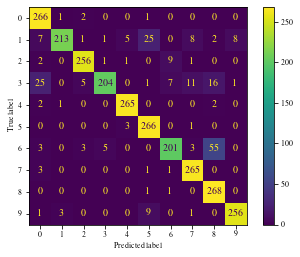

Classification training report for estimator SeqToLabelESNClassifier(input_to_node=InputToNode(hidden_layer_size=100,
                                                  input_activation='identity',
                                                  input_scaling=0.30000000000000004,
                                                  k_in=10,
                                                  sparsity=0.7692307692307693),
                        node_to_node=NodeToNode(continuation=False,
                                                hidden_layer_size=100, k_rec=10,
                                                leakage=0.1, sparsity=0.1,
                                                spectral_radius=0.7000000000000001),
                        regressor=IncrementalRegression()):
              precision    recall  f1-score   support

           0  0.8608414239 0.9851851852 0.9188255613       270
           1  0.9770642202 0.7888888889 0.8729508197       270
           2  0.9588014981 0.

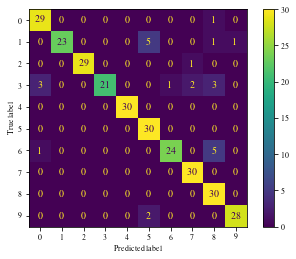

Classification test report for estimator SeqToLabelESNClassifier(input_to_node=InputToNode(hidden_layer_size=100,
                                                  input_activation='identity',
                                                  input_scaling=0.30000000000000004,
                                                  k_in=10,
                                                  sparsity=0.7692307692307693),
                        node_to_node=NodeToNode(continuation=False,
                                                hidden_layer_size=100, k_rec=10,
                                                leakage=0.1, sparsity=0.1,
                                                spectral_radius=0.7000000000000001),
                        regressor=IncrementalRegression()):
              precision    recall  f1-score   support

           0  0.8787878788 0.9666666667 0.9206349206        30
           1  1.0000000000 0.7666666667 0.8679245283        30
           2  1.0000000000 0.9666

In [27]:
y_pred_train = km_esn.predict(X=X_train_scaled)
cm = confusion_matrix(y_train, y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
plt.show()
print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(y_train, y_pred_train, digits=10)))

y_pred_test = km_esn.predict(X=X_test_scaled)
cm = confusion_matrix(y_test, y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
plt.show()
print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(y_test, y_pred_test, digits=10)))

In [28]:
sequential_search.all_best_params_

{'step1': {'input_scaling': 0.7000000000000001, 'spectral_radius': 0.8},
 'step2': {'leakage': 0.1},
 'step3': {'bias_scaling': 1.0},
 'step4': {'alpha': 1e-05}}

Visualization of a reservoir state from the training set

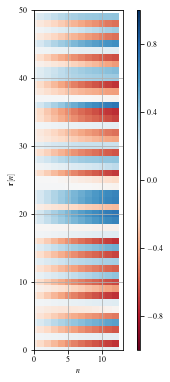

In [29]:
_ = km_esn.predict(X=X_train_scaled[361])
fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
ax = plt.gca()
rng = np.random.default_rng(12345)
idx = rng.choice(100, 50)
im = plt.imshow(km_esn.hidden_layer_state[:, idx].T,vmin=-1, vmax=1)
plt.xlim([0, km_esn.hidden_layer_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.grid()
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
tick_locator = ticker.MaxNLocator(nbins=5)
cb = plt.colorbar(im, cax=cax)
cb.locator = tick_locator
cb.update_ticks()
fig.set_size_inches(0.5*width, height)
# plt.savefig('input_scaling_rand_train.pdf', bbox_inches = 'tight', pad_inches = 0)

# print(f_name_train[361])

Visualization of a reservoir state from the test set

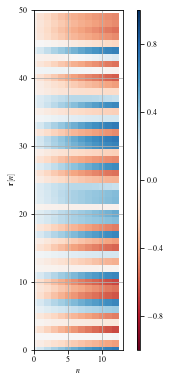

In [30]:
_ = km_esn.predict(X=X_test_scaled[0])
fig = plt.figure()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
ax = plt.gca()
rng = np.random.default_rng(12345)
idx = rng.choice(100, 50)
im = plt.imshow(km_esn.hidden_layer_state[:, idx].T,vmin=-1, vmax=1)
plt.xlim([0, km_esn.hidden_layer_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.grid()
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cb = plt.colorbar(im, cax=cax)
cb.locator = tick_locator
cb.update_ticks()
fig.set_size_inches(0.5*width, height)
# plt.savefig('spectral_radius_rand_test.pdf', bbox_inches = 'tight', pad_inches = 0)

Random experiments

In [31]:
rng = np.random.default_rng(12345)
params = {"random_state": rng.integers(100, size=20)}
gs_km_esn = GridSearchCV(clone(km_esn), params, scoring=make_scorer(accuracy_score), n_jobs=-1).fit(X_train_scaled, y_train)

In [33]:
gs_km_esn.cv_results_["mean_test_score"].mean(), gs_km_esn.cv_results_["mean_test_score"].var()

(0.8953703703703706, 8.225651577503388e-05)

In [35]:
import time
print("Training K-Means ...")
t1 = time.time()
kmeans = MiniBatchKMeans(n_clusters=500, random_state=42, n_init=20, reassignment_ratio=0, max_no_improvement=50, init='k-means++').fit(np.concatenate(X_train_scaled))
print("... done in {0} seconds.".format(time.time() - t1))

Training K-Means ...


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\App

... done in 17.27431583404541 seconds.


In [45]:
import time
print("Training Birch ...")
t1 = time.time()
birch = Birch(threshold=1, n_clusters=None).fit(np.concatenate(X_train_scaled))
print("... done in {0} seconds.".format(time.time() - t1))
birch.subcluster_centers_.shape

Training Birch ...
... done in 87.77899050712585 seconds.


(36682, 13)